In [54]:
# take voter fatigue and news into account
# train on only more recent years
# use share

In [55]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn

In [56]:
df = pd.read_csv('data.csv')
df.head()

,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,Bob Pettit,23,STL,33.0,33.0,80,0.413,72,38.8,25.7,16.2,2.6,NaN,NaN,0.429,NaN,0.736,13.8,0.236
1,Paul Arizin,27,PHW,21.0,21.0,80,0.263,72,37.8,24.2,7.5,2.6,NaN,NaN,0.448,NaN,0.810,12.2,0.214
2,Bob Cousy,27,BOS,11.0,11.0,80,0.138,72,38.4,18.8,6.8,8.9,NaN,NaN,0.360,NaN,0.844,6.8,0.119
3,Mel Hutchins,27,FTW,9.0,9.0,80,0.113,66,33.9,12.0,7.5,2.7,NaN,NaN,0.425,NaN,0.643,4.4,0.095
4,Dolph Schayes,27,SYR,2.0,2.0,80,0.025,72,35.0,20.4,12.4,2.8,NaN,NaN,0.387,NaN,0.858,11.8,0.225


In [57]:
cur_stats = pd.read_csv('current_stats.csv')
cur_stats_adv = pd.read_csv('current_stats_adv.csv')

cur_stats['WS'] = cur_stats_adv['WS']
cur_stats['WS/48'] = cur_stats_adv['WS/48']
cur_stats = cur_stats.drop(['Tm'], axis=1)

cur_stats = cur_stats.drop([col for col in cur_stats.columns if col not in df.columns], axis=1)
cur_stats.head()

,Player,Age,G,MP,FG%,3P%,FT%,TRB,AST,STL,BLK,PTS,WS,WS/48
0,Precious Achiuwa,23,34,23.3,0.486,0.247,0.684,6.5,1.1,0.7,0.7,10.4,1.6,0.099
1,Steven Adams,29,42,27.0,0.597,0.000,0.364,11.5,2.3,0.9,1.1,8.6,3.4,0.145
2,Bam Adebayo,25,52,35.3,0.546,0.091,0.806,10.1,3.3,1.2,0.8,21.6,6.1,0.159
3,Ochai Agbaji,22,35,14.0,0.486,0.394,0.625,1.6,0.5,0.1,0.1,4.1,0.7,0.068
4,Santi Aldama,22,53,22.1,0.477,0.367,0.738,4.7,1.2,0.7,0.7,9.5,3.6,0.146


In [58]:
# Remove Player and Team and drop duplicate
df = df.drop(['Player', 'Tm'], axis=1)
df.head()

,Age,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,23,33.0,33.0,80,0.413,72,38.8,25.7,16.2,2.6,NaN,NaN,0.429,NaN,0.736,13.8,0.236
1,27,21.0,21.0,80,0.263,72,37.8,24.2,7.5,2.6,NaN,NaN,0.448,NaN,0.810,12.2,0.214
2,27,11.0,11.0,80,0.138,72,38.4,18.8,6.8,8.9,NaN,NaN,0.360,NaN,0.844,6.8,0.119
3,27,9.0,9.0,80,0.113,66,33.9,12.0,7.5,2.7,NaN,NaN,0.425,NaN,0.643,4.4,0.095
4,27,2.0,2.0,80,0.025,72,35.0,20.4,12.4,2.8,NaN,NaN,0.387,NaN,0.858,11.8,0.225


In [59]:
# Setting NaN features to the average

# Calculating average
df_mean = df.dropna()
mean_vals = df_mean.mean()

# Setting values
for row in range(len(df)):
    for i, val in enumerate(df.iloc[row]):
        if np.isnan(val):
            df.iat[row,i] = mean_vals[i]

df.head()

,Age,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,23,33.0,33.0,80,0.413,72,38.8,25.7,16.2,2.6,1.443964,0.926528,0.429,0.271572,0.736,13.8,0.236
1,27,21.0,21.0,80,0.263,72,37.8,24.2,7.5,2.6,1.443964,0.926528,0.448,0.271572,0.810,12.2,0.214
2,27,11.0,11.0,80,0.138,72,38.4,18.8,6.8,8.9,1.443964,0.926528,0.360,0.271572,0.844,6.8,0.119
3,27,9.0,9.0,80,0.113,66,33.9,12.0,7.5,2.7,1.443964,0.926528,0.425,0.271572,0.643,4.4,0.095
4,27,2.0,2.0,80,0.025,72,35.0,20.4,12.4,2.8,1.443964,0.926528,0.387,0.271572,0.858,11.8,0.225


In [60]:
# Dropping First, Pts Won, and Pts Max. Using MVP shares for as the predicted value
df = df.drop(['First', 'Pts Won', 'Pts Max'], axis=1)
df.tail()

,Age,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
1018,33,0.004,64,34.5,25.5,5.2,6.3,1.3,0.4,0.437,0.380,0.923,8.0,0.173
1019,36,0.002,65,32.9,14.7,4.4,10.8,1.9,0.3,0.493,0.317,0.837,9.4,0.210
1020,32,0.001,76,36.1,27.9,5.2,4.9,0.9,0.3,0.504,0.352,0.877,8.8,0.154
1021,33,0.001,55,37.2,29.9,7.4,6.4,0.9,0.9,0.518,0.383,0.910,8.4,0.198
1022,37,0.001,56,37.2,30.3,8.2,6.2,1.3,1.1,0.524,0.359,0.756,7.5,0.172


In [61]:
full_df = pd.concat([cur_stats, df])
normalized_df = full_df.drop(['Player', 'Share'], axis=1)
normalized_df

,Age,G,MP,FG%,3P%,FT%,TRB,AST,STL,BLK,PTS,WS,WS/48
0,23,34,23.3,0.486,0.247,0.684,6.5,1.1,0.7,0.7,10.4,1.6,0.099
1,29,42,27.0,0.597,0.000,0.364,11.5,2.3,0.9,1.1,8.6,3.4,0.145
2,25,52,35.3,0.546,0.091,0.806,10.1,3.3,1.2,0.8,21.6,6.1,0.159
3,22,35,14.0,0.486,0.394,0.625,1.6,0.5,0.1,0.1,4.1,0.7,0.068
4,22,53,22.1,0.477,0.367,0.738,4.7,1.2,0.7,0.7,9.5,3.6,0.146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,33,64,34.5,0.437,0.380,0.923,5.2,6.3,1.3,0.4,25.5,8.0,0.173
1019,36,65,32.9,0.493,0.317,0.837,4.4,10.8,1.9,0.3,14.7,9.4,0.210
1020,32,76,36.1,0.504,0.352,0.877,5.2,4.9,0.9,0.3,27.9,8.8,0.154
1021,33,55,37.2,0.518,0.383,0.910,7.4,6.4,0.9,0.9,29.9,8.4,0.198


In [62]:
normalized_df = (normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())
normalized_df['Player'] = full_df['Player']
normalized_df['Share'] = full_df['Share']
normalized_df

,Age,G,MP,FG%,3P%,FT%,TRB,AST,STL,BLK,PTS,WS,WS/48,Player,Share
0,0.173913,0.407407,0.480412,0.486,0.247,0.684,0.238971,0.075862,0.175,0.125000,0.206349,0.081081,0.458207,Precious Achiuwa,NaN
1,0.434783,0.506173,0.556701,0.597,0.000,0.364,0.422794,0.158621,0.225,0.196429,0.170635,0.150579,0.481370,Steven Adams,NaN
2,0.260870,0.629630,0.727835,0.546,0.091,0.806,0.371324,0.227586,0.300,0.142857,0.428571,0.254826,0.488419,Bam Adebayo,NaN
3,0.130435,0.419753,0.288660,0.486,0.394,0.625,0.058824,0.034483,0.025,0.017857,0.081349,0.046332,0.442598,Ochai Agbaji,NaN
4,0.130435,0.641975,0.455670,0.477,0.367,0.738,0.172794,0.082759,0.175,0.125000,0.188492,0.158301,0.481873,Santi Aldama,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,0.608696,0.777778,0.711340,0.437,0.380,0.923,0.191176,0.434483,0.325,0.071429,0.505952,0.328185,0.495468,NaN,0.004
1019,0.739130,0.790123,0.678351,0.493,0.317,0.837,0.161765,0.744828,0.475,0.053571,0.291667,0.382239,0.514099,NaN,0.002
1020,0.565217,0.925926,0.744330,0.504,0.352,0.877,0.191176,0.337931,0.225,0.053571,0.553571,0.359073,0.485901,NaN,0.001
1021,0.608696,0.666667,0.767010,0.518,0.383,0.910,0.272059,0.441379,0.225,0.160714,0.593254,0.343629,0.508056,NaN,0.001


In [63]:
# normalized_df = normalized_df[['WS','WS/48', 'Player', 'Share']]

In [64]:
data = normalized_df.loc[normalized_df['Player'].isna()].drop(['Player'], axis=1).to_numpy()
y = data[:, -1]
data = np.delete(data, -1, axis=1)
X = data
X, y

(array([[0.55212355, 0.52719033],
        [0.49034749, 0.51611279],
        [0.28185328, 0.46827795],
        ...,
        [0.35907336, 0.48590131],
        [0.34362934, 0.50805639],
        [0.30888031, 0.49496475]]),
 array([0.413, 0.263, 0.138, ..., 0.001, 0.001, 0.001]))

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = list(map(lambda x: torch.FloatTensor(x), train_test_split(X, y, test_size=0.1, random_state=0)))
X_train, y_train

(tensor([[0.2857, 0.4607],
         [0.4170, 0.4864],
         [0.4286, 0.5101],
         ...,
         [0.2857, 0.4945],
         [0.5560, 0.5393],
         [0.2973, 0.4950]]),
 tensor([0.0100, 0.0350, 0.0020, 0.0050, 0.7260, 0.0010, 0.0250, 0.0040, 0.4010,
         0.0130, 0.0040, 0.2170, 0.0320, 0.0210, 0.0010, 0.0010, 0.0020, 0.0020,
         0.1490, 0.3590, 0.0090, 0.3050, 0.0830, 0.0420, 0.0200, 0.1080, 0.0750,
         0.0170, 0.0010, 0.0050, 0.0040, 0.0380, 0.0200, 0.7120, 0.0080, 0.8790,
         0.0030, 0.3190, 0.0030, 0.1760, 0.2000, 0.5620, 0.0010, 0.1670, 0.0030,
         0.5220, 0.2880, 0.0010, 0.0020, 0.7540, 0.0040, 0.0040, 0.0020, 0.0010,
         0.0750, 0.0270, 0.0010, 0.0200, 0.7730, 0.0010, 0.0050, 0.0010, 0.0030,
         0.1730, 0.0070, 0.0240, 0.0460, 0.0230, 0.0020, 0.0020, 0.0070, 0.0100,
         0.1090, 0.1560, 0.0100, 0.1510, 0.0050, 0.6670, 0.0010, 0.0050, 0.3860,
         0.0050, 0.0150, 0.0030, 0.0690, 0.0010, 0.1400, 0.0140, 0.0930, 0.0040,
         0.0

In [66]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers
        self.m1 = nn.Linear(X.shape[1], 128)
        self.f1 = nn.LeakyReLU()
        self.m2 = nn.Linear(128, 128)
        self.f2 = nn.LeakyReLU()
        self.m3 = nn.Linear(128, 64)
        self.f3 = nn.LeakyReLU()
        self.m4 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.m1(x)
        x = self.f1(x)
        x = self.m2(x)
        x = self.f2(x)
        x = self.m3(x)
        x = self.f3(x)
        x = self.m4(x)
        return x


In [67]:
model = Network()

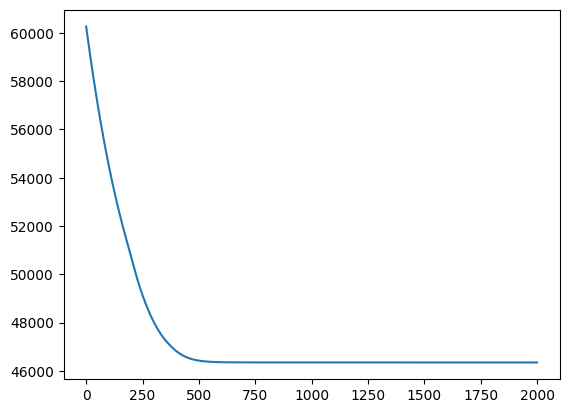

In [68]:
# Hyperparameters
learning_rate = 5e-6
num_epochs = 2000

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Model
train_loss = []
epoch_durs = []
for epoch in range(num_epochs):
  output = model(X_train)
  loss = torch.sum((output - y_train)**2)
  train_loss.append(loss.item())
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  print(f'epoch {epoch} of {num_epochs} loss: {loss.item()}\t\t\t\t\t\t\t\t', end='\r')

plt.plot(range(len(train_loss)), train_loss)
plt.show()

In [69]:
output = model(X_val)
output = output.detach()
val_df = pd.DataFrame(np.hstack([output, y_val.reshape(-1, 1)]),
                      columns=['Pred', 'Actual'])
print(val_df.mean())
val_df

Pred      0.142186
Actual    0.158476
dtype: float32


,Pred,Actual
0,0.143361,0.785
1,0.142287,0.020
2,0.139537,0.005
3,0.141912,0.219
4,0.142077,0.031
...,...,...
98,0.140790,0.003
99,0.141585,0.004
100,0.142767,0.001
101,0.140885,0.577


In [70]:
cur_df = normalized_df.loc[normalized_df['Share'].isna()].drop(['Share'], axis=1)
cur_val_df = pd.DataFrame(columns=['Pred'], data=model(torch.FloatTensor(cur_df.drop(['Player'], axis=1).to_numpy())).detach())
cur_val_df['Player'] = normalized_df.loc[normalized_df['Share'].isna()]['Player']
cur_val_df = cur_val_df.sort_values(by=['Pred'])
cur_val_df = cur_val_df.dropna()
cur_val_df[-50:]

,Pred,Player
172,0.142911,Rudy Gobert
174,0.142965,Aaron Gordon
402,0.142990,Mason Plumlee
240,0.143010,Kyrie Irving
305,0.143026,Kawhi Leonard
350,0.143040,Josh Minott
194,0.143127,Tyrese Haliburton
352,0.143133,Donovan Mitchell
486,0.143295,Jayson Tatum
413,0.143327,Micah Potter


In [71]:
y_pred = model(X_val)
y_pred = y_pred.detach().reshape(1, -1)[0]
sklearn.metrics.r2_score(y_val, y_pred)

-0.0032295943487679057

In [72]:
# https://stats.stackexchange.com/questions/261704/training-a-neural-network-for-regression-always-predicts-the-mean

# Make github
# Predict rank
# Use advanced stats
# Normalize each column
# Add lr decay
# Normalize (train and test with all types of normalization)